In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import gmsh
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import scipy.interpolate
import scipy.sparse

from femns2d import femns2d

In [3]:
%load_ext autoreload
%autoreload 2

In [33]:
def create_unit_square_mesh(name="unit_square.msh"):
    gmsh.initialize()
    gmsh.model.add('unit_square')
    
    pfactor = 0.1
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, -1, 0, pfactor, 1)
    gmsh.model.geo.addPoint(5, -1, 0, pfactor, 2)
    gmsh.model.geo.addPoint(5, 1, 0, pfactor, 3)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 4)

    # Connect points with lines to form unit square
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)

    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1], 1)
    gmsh.model.geo.addPhysicalGroup(1, [2], 2)
    gmsh.model.geo.addPhysicalGroup(1, [3], 3)
    gmsh.model.geo.addPhysicalGroup(1, [4], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('unit_square.msh')

    gmsh.finalize()

In [34]:
create_unit_square_mesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000611366s, CPU 0.000829s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0587165s, CPU 0.058956s)
Info    : 1247 nodes 2496 elements
Info    : Writing 'unit_square.msh'...
Info    : Done writing 'unit_square.msh'


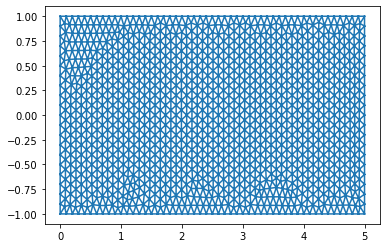

In [35]:
# Read the mesh file
mesh = meshio.read("unit_square.msh")

# Calculate centroids for each triangle cell
points = mesh.points[:, :-1]
triangles = mesh.cells_dict["triangle"]
centroids = np.mean(points[triangles], axis=1)
boundary_centroids = np.mean(points[mesh.cells_dict["line"]], axis=1)
# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

# Annotate points
if points.shape[0] < 50:
    for i, p in enumerate(points):
        x, y = p[0], p[1]
        ax.annotate(str(i), (x+0.01, y+0.05), color='blue')

    # Annotate cells at their centroids
    for i, (cx, cy) in enumerate(centroids):
        ax.annotate(str(i), (cx, cy), color='red')
        
    # Annotate cells at their centroids
    for i, (bcx, bcy) in enumerate(boundary_centroids):
        ax.annotate(str(i), (bcx, bcy), color='green')

        

plt.show()

In [36]:
# dirichlet_bcs_u = [[0, 0], [1, 3]]
# dirichlet_bcs_v = [[0, 0], [1, 3]]
# dirichlet_bcs_p = [[5, 0], [4, 2]]
assembler = femns2d.MiniAssembler(mesh)
Re = 1.0
ex = np.array([1.0, 0.0])
ey = np.array([0.0, 1.0])
body_force_x = 0.0
body_force_y = -1.0

K = assembler.stiffness_matrix(1/Re)
Azero = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
Azerop = scipy.sparse.dok_matrix((assembler.npoints, assembler.npoints))
Guxp = assembler.velocity_pressure_convection_matrix(ex)
Guyp = assembler.velocity_pressure_convection_matrix(ey)
Gpux = assembler.velocity_pressure_convection_matrix(ex).T
Gpuy = assembler.velocity_pressure_convection_matrix(ey).T
Au = scipy.sparse.bmat([[K, Azero, Guxp]])
Av = scipy.sparse.bmat([[Azero, K, Guyp]])
Ap = scipy.sparse.bmat([[Gpux, Gpuy, Azerop]])
A = scipy.sparse.bmat([[Au], [Av], [Ap]])
A = scipy.sparse.dok_matrix(A)
u_bc_func = lambda x : 1-(x[..., 1]**2)
# u_bc_func = 1.0
velocity_markers = [4, 1, 3]
pressure_markers = [2]
dirichlet_bcs_u = [[u_bc_func, 0, 0], velocity_markers]
dirichlet_bcs_v = [[u_bc_func, 0, 0], velocity_markers]
dirichlet_bcs_p = [[0], pressure_markers]

A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], A, 'p', excluded_markers=velocity_markers)
A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_u[1], A, 'u')
A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_v[1], A, 'v')
f = np.hstack([assembler.forcing_vector(0.0),
               assembler.forcing_vector(0.0),
               assembler.forcing_vector(0.0)[:assembler.npoints]])

f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, f, 'p', excluded_markers=velocity_markers)
f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_u, f, 'u')
f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_v, f, 'v')


In [37]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
ax.matshow(A.toarray() != 0)

Error in callback <function flush_figures at 0x7f508d8758b0> (for post_execute):


KeyboardInterrupt: 

In [28]:
A_sparse = A.tocsc()
uxyp = scipy.sparse.linalg.spsolve(A_sparse, f)

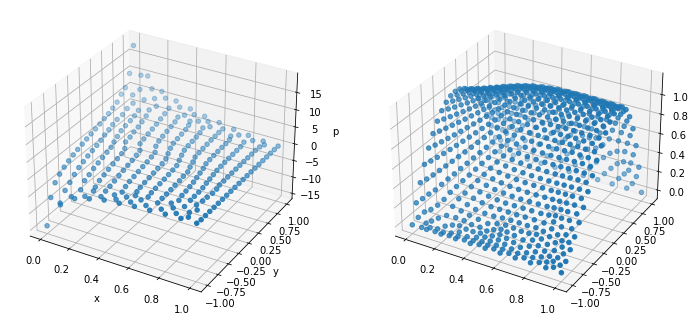

In [29]:
def split_velocities(uxyp):
    n = assembler.npoints + assembler.nelements
    ux = uxyp[..., :n]
    uy = uxyp[..., n:2*n]
    p = uxyp[..., 2*n:]
    return ux, uy, p
ux, uy, p = split_velocities(uxyp)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121, projection='3d')
xp, yp = assembler.points[:, 0], assembler.points[:, 1]
ax.scatter(xp, yp, p)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p")
ax = fig.add_subplot(122, projection='3d')
xe, ye = assembler.pointse[:, 0], assembler.pointse[:, 1]
ue = np.sqrt(ux**2 + uy**2)
ax.scatter(xe, ye, ux)

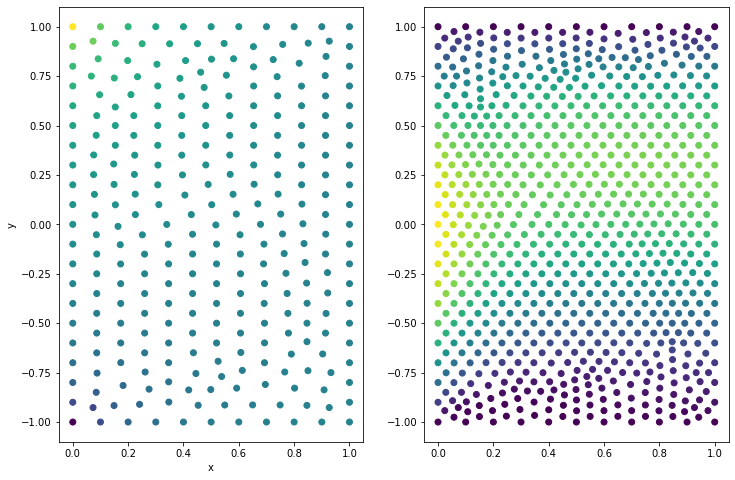

In [30]:
def split_velocities(uxyp):
    n = assembler.npoints + assembler.nelements
    ux = uxyp[..., :n]
    uy = uxyp[..., n:2*n]
    p = uxyp[..., 2*n:]
    return ux, uy, p
ux, uy, p = split_velocities(uxyp)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121)
xp, yp = assembler.points[:, 0], assembler.points[:, 1]
ax.scatter(xp, yp, c=p)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax = fig.add_subplot(122)
xe, ye = assembler.pointse[:, 0], assembler.pointse[:, 1]
ue = np.sqrt(ux**2 + uy**2)
ax.scatter(xe, ye, c=ue)

In [31]:
p

array([-1.42822614e+01,  2.06524002e-01, -3.26680297e-02,  1.81650572e+01,
       -6.69675626e+00, -3.55358452e+00, -2.28330671e+00, -1.29942800e+00,
       -8.84734549e-01, -4.48298698e-01, -2.00023881e-01,  3.26459700e-02,
        1.86844416e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.15098714e-01,  7.13257723e-01,  1.29217317e+00,  2.12990087e+00,
        2.81824481e+00,  3.85529149e+00,  5.04426171e+00,  6.77133638e+00,
        1.02590539e+01,  1.08829654e+01,  7.60499180e+00,  6.62660579e+00,
        5.24864777e+00,  4.48631555e+00,  3.83631182e+00,  3.35848036e+00,
        2.82885959e+00,  2.38882753e+00,  1.95650720e+00,  1.50752925e+00,
        1.02944295e+00,  

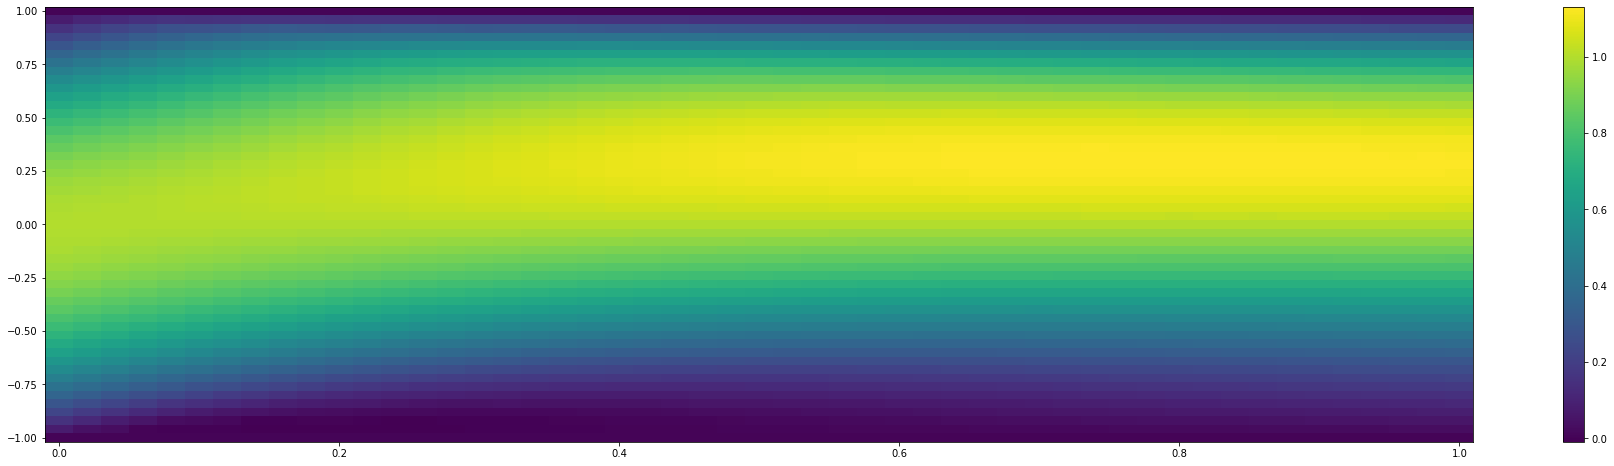

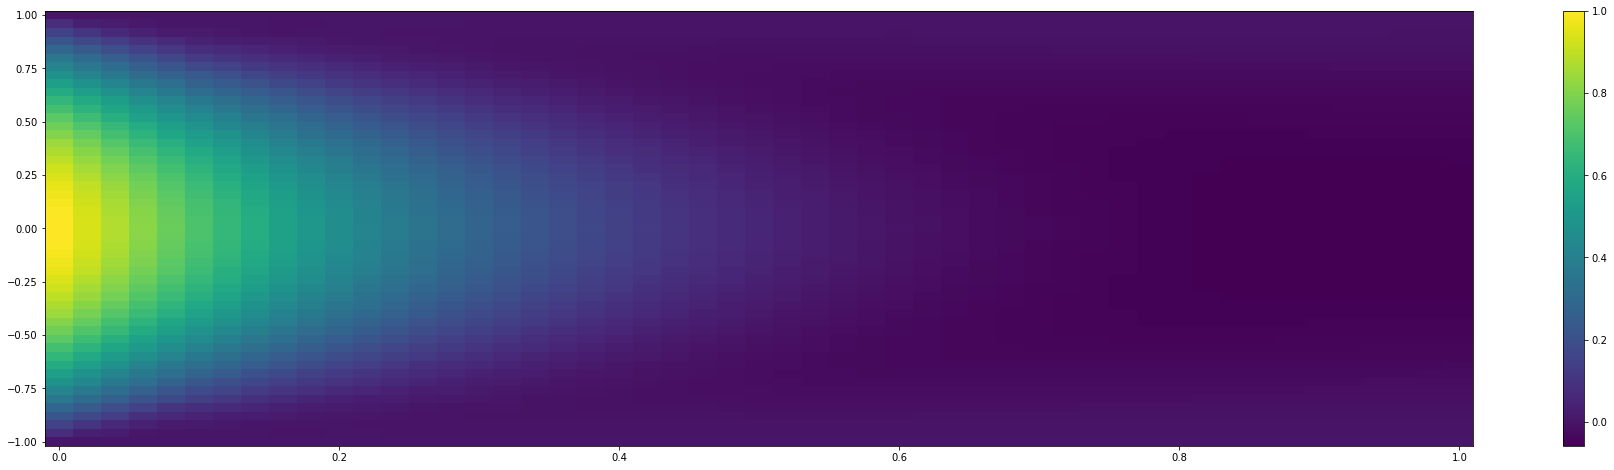

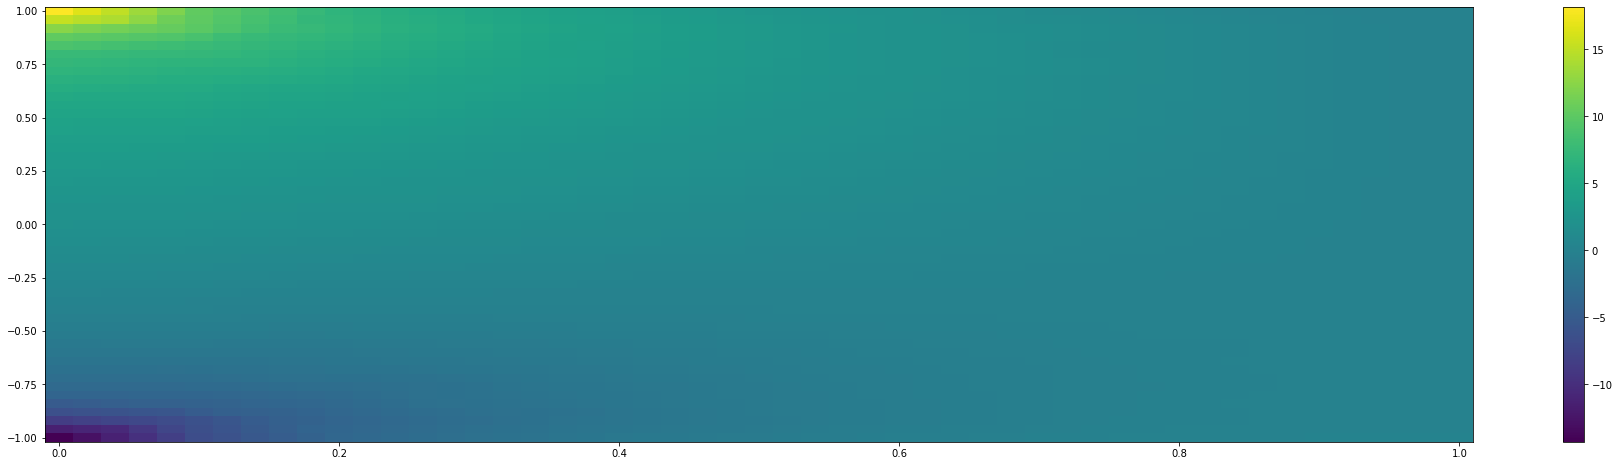

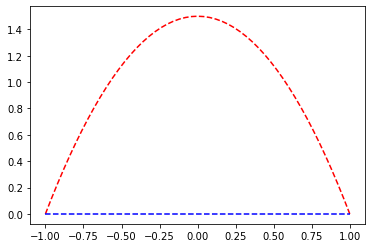

In [32]:
def split_velocities(uxyp):
    n = assembler.npoints + assembler.nelements
    ux = uxyp[..., :n]
    uy = uxyp[..., n:2*n]
    p = uxyp[..., 2*n:]
    return ux, uy, p
ux, uy, p = split_velocities(uxyp)
ux_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], ux)
uy_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], uy)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], p)

X, Y = np.meshgrid(np.linspace(0, 1, 51), np.linspace(-1, 1, 51))
UX = ux_interp(X, Y)
UY = uy_interp(X, Y)
P = p_interp(X, Y)
for Z in [UX, UY, P]:
    plt.figure(figsize=(32, 8))
    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar()

n = 51
x = np.ones(n)*8.0
y = np.linspace(-1, 1, n)
ux = ux_interp(x, y)
uy = uy_interp(x, y)

plt.figure()
plt.plot(y, ux, 'r')
plt.plot(y, uy, 'b')
plt.plot(y, 1.5*(1-y**2), 'r--')
plt.plot(y, 0.0*y, 'b--')